# PaperPal (By YuChiChen)

## 1. Environment Building

### 連接 Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### 安裝 Detectron 2

In [ ]:
!pip install torch torchvision torchaudio cython pycocotools pyyaml --index-url https://download.pytorch.org/whl/cpu

In [ ]:
!pip install "git+https://github.com/facebookresearch/detectron2.git"

In [ ]:
!pip install detectron2

### 安裝 Tesseract

In [ ]:
!sudo apt install poppler-utils tesseract-ocr

In [ ]:
!pip install pytesseract

In [ ]:
!pip install pdf2image layoutparser opencv-python-headless pillow "layoutparser[ocr]"

### 安裝 RAG (Retrieval-Augmented Generation) Library

In [ ]:
!pip install langchain langchain-community pydantic lxml openai chromadb tiktoken faiss-cpu # faiss-gpu

## 2. PDF Extraction

### 報錯一
> RuntimeError: operator torchvision::nms does not exist
>
- 先執行一次 「PDF Extracting & Parsing」
- uninstall 及 install torchvision 一次
- 再執行一次 「PDF Extracting & Parsing」

In [ ]:
!pip uninstall torchvision

In [ ]:
!pip install torchvision

### 報錯二
> AssertionError: Checkpoint /root/.torch/iopath_cache/s/57zjbwv6gh3srry/model_final.pth not found!
>
- 先執行一次 「PDF Extracting & Parsing」
- 先把第 43 行註解掉
- 把 "/root/.torch/iopath_cache/s/57zjbwv6gh3srry/model_final.pth?dl=1" 改成 "/root/.torch/iopath_cache/s/57zjbwv6gh3srry/model_final.pth"
- 取消第 43 行註解，並再執行一次「PDF Extracting & Parsing」

### PDF Extracting & Parsing
- DIA (Document Image Analysis) - Detectron2
- OCR (Optical Character Recognition) - Tesseract

In [ ]:
import io
import os
import pdf2image
import layoutparser as lp
import cv2
import pytesseract
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

DRIVE_PDF = '/content/drive/My Drive/GraphRAG.pdf'
MODEL_PATH = "/root/.torch/iopath_cache/s/57zjbwv6gh3srry/model_final.pth"   # Detectron2 環境問題
X_TOLERANCE = 600   # OCR 物件判別時，使x軸在一定區間內的值相同
CONFIDENCE_THRESHOLD = 0.5
text_content = []   # 儲存所有文字內容

# PDF2Image：將 PDF 的每頁轉為圖片
def save_pdf_pages_img(drive_pdf):
  # Read PDF as an image
  pdf_name = os.path.splitext(os.path.basename(drive_pdf))[0]
  drive_folder = os.path.join(os.path.dirname(drive_pdf), pdf_name)
  doc = pdf2image.convert_from_path(drive_pdf)
  # Save each page as images & Create folders
  if not os.path.exists(drive_folder):
    os.makedirs(drive_folder)
    page_img_folder = os.path.join(os.path.join(drive_folder), 'Page')
    if not os.path.exists(page_img_folder):
      os.makedirs(page_img_folder)
    for i in range(len(doc)):
      doc[i].save(f'{page_img_folder}/page{i + 1}.jpg', 'JPEG')
    fig_folder = os.path.join(os.path.join(drive_folder), 'Figure')
    if not os.path.exists(fig_folder):
      os.makedirs(fig_folder)
    table_folder = os.path.join(os.path.join(drive_folder), 'Table')
    if not os.path.exists(table_folder):
      os.makedirs(table_folder)
  return drive_folder, page_img_folder, fig_folder, table_folder, doc

# Detectron2：檢測每頁的內容
layout_model = lp.Detectron2LayoutModel(
                config_path='lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config', # In model catalog
                model_path=MODEL_PATH, # In model path
                label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"}, # In model label_map
                extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", CONFIDENCE_THRESHOLD] # Optional
            )

# 排版偵測：以x軸為主，y軸為輔，並設定x軸誤差區間
def custom_sort_key(block):
  x1, y1, x2, y2 = block.coordinates
  x_group = x1 // X_TOLERANCE
  return (x_group, y1)

# Detect objects in page images
def parse_pdf(drive_folder, page_img_folder, fig_folder, table_folder, pdf):
  fig_num = 0
  table_num = 0
  for i in range(len(pdf)):
    img = np.asarray(pdf[i])
    detected = layout_model.detect(img)
    sorted_detected = sorted(detected, key=custom_sort_key)
    text_per_page = []
    for block in sorted_detected:
      # Text
      if block.type=='Text' or block.type=='Title' or block.type=='List':
        text_per_page.append(block)
      # Figure
      elif block.type=='Figure':
        # Figure extraction
        x1, y1, x2, y2 = map(int, block.coordinates)
        cropped_img = Image.fromarray(img).crop((x1, y1, x2, y2))
        # Figure storage
        fig_num += 1
        fig_path = os.path.join(fig_folder, f'figure_{fig_num}.png')
        cropped_img.save(fig_path)
      # Table
      elif block.type=='Table':
        # Table extraction
        x1, y1, x2, y2 = map(int, block.coordinates)
        cropped_img = Image.fromarray(img).crop((x1, y1, x2, y2))
        # Table storage
        table_num += 1
        table_path = os.path.join(table_folder, f'table_{table_num}.png')
        cropped_img.save(table_path)
    # Text extraction
    for text_block in text_per_page:
      segmented = text_block.pad(left=15, right=15, top=5, bottom=5).crop_image(img)
      # 使用 Tesseract OCR 識別文本
      ocr_agent = lp.TesseractAgent(languages='eng')
      extracted_text = ocr_agent.detect(segmented)
      text_content.append(extracted_text)
  # Text storage
  with open(f'{drive_folder}/text.txt', 'w', encoding='utf-8') as file:
    for line in text_content:
      file.write(line + '\n')



drive_folder, page_img_folder, fig_folder, table_folder, pdf = save_pdf_pages_img(DRIVE_PDF)
parse_pdf(drive_folder, page_img_folder, fig_folder, table_folder, pdf)


### Showing Layout for Each Page

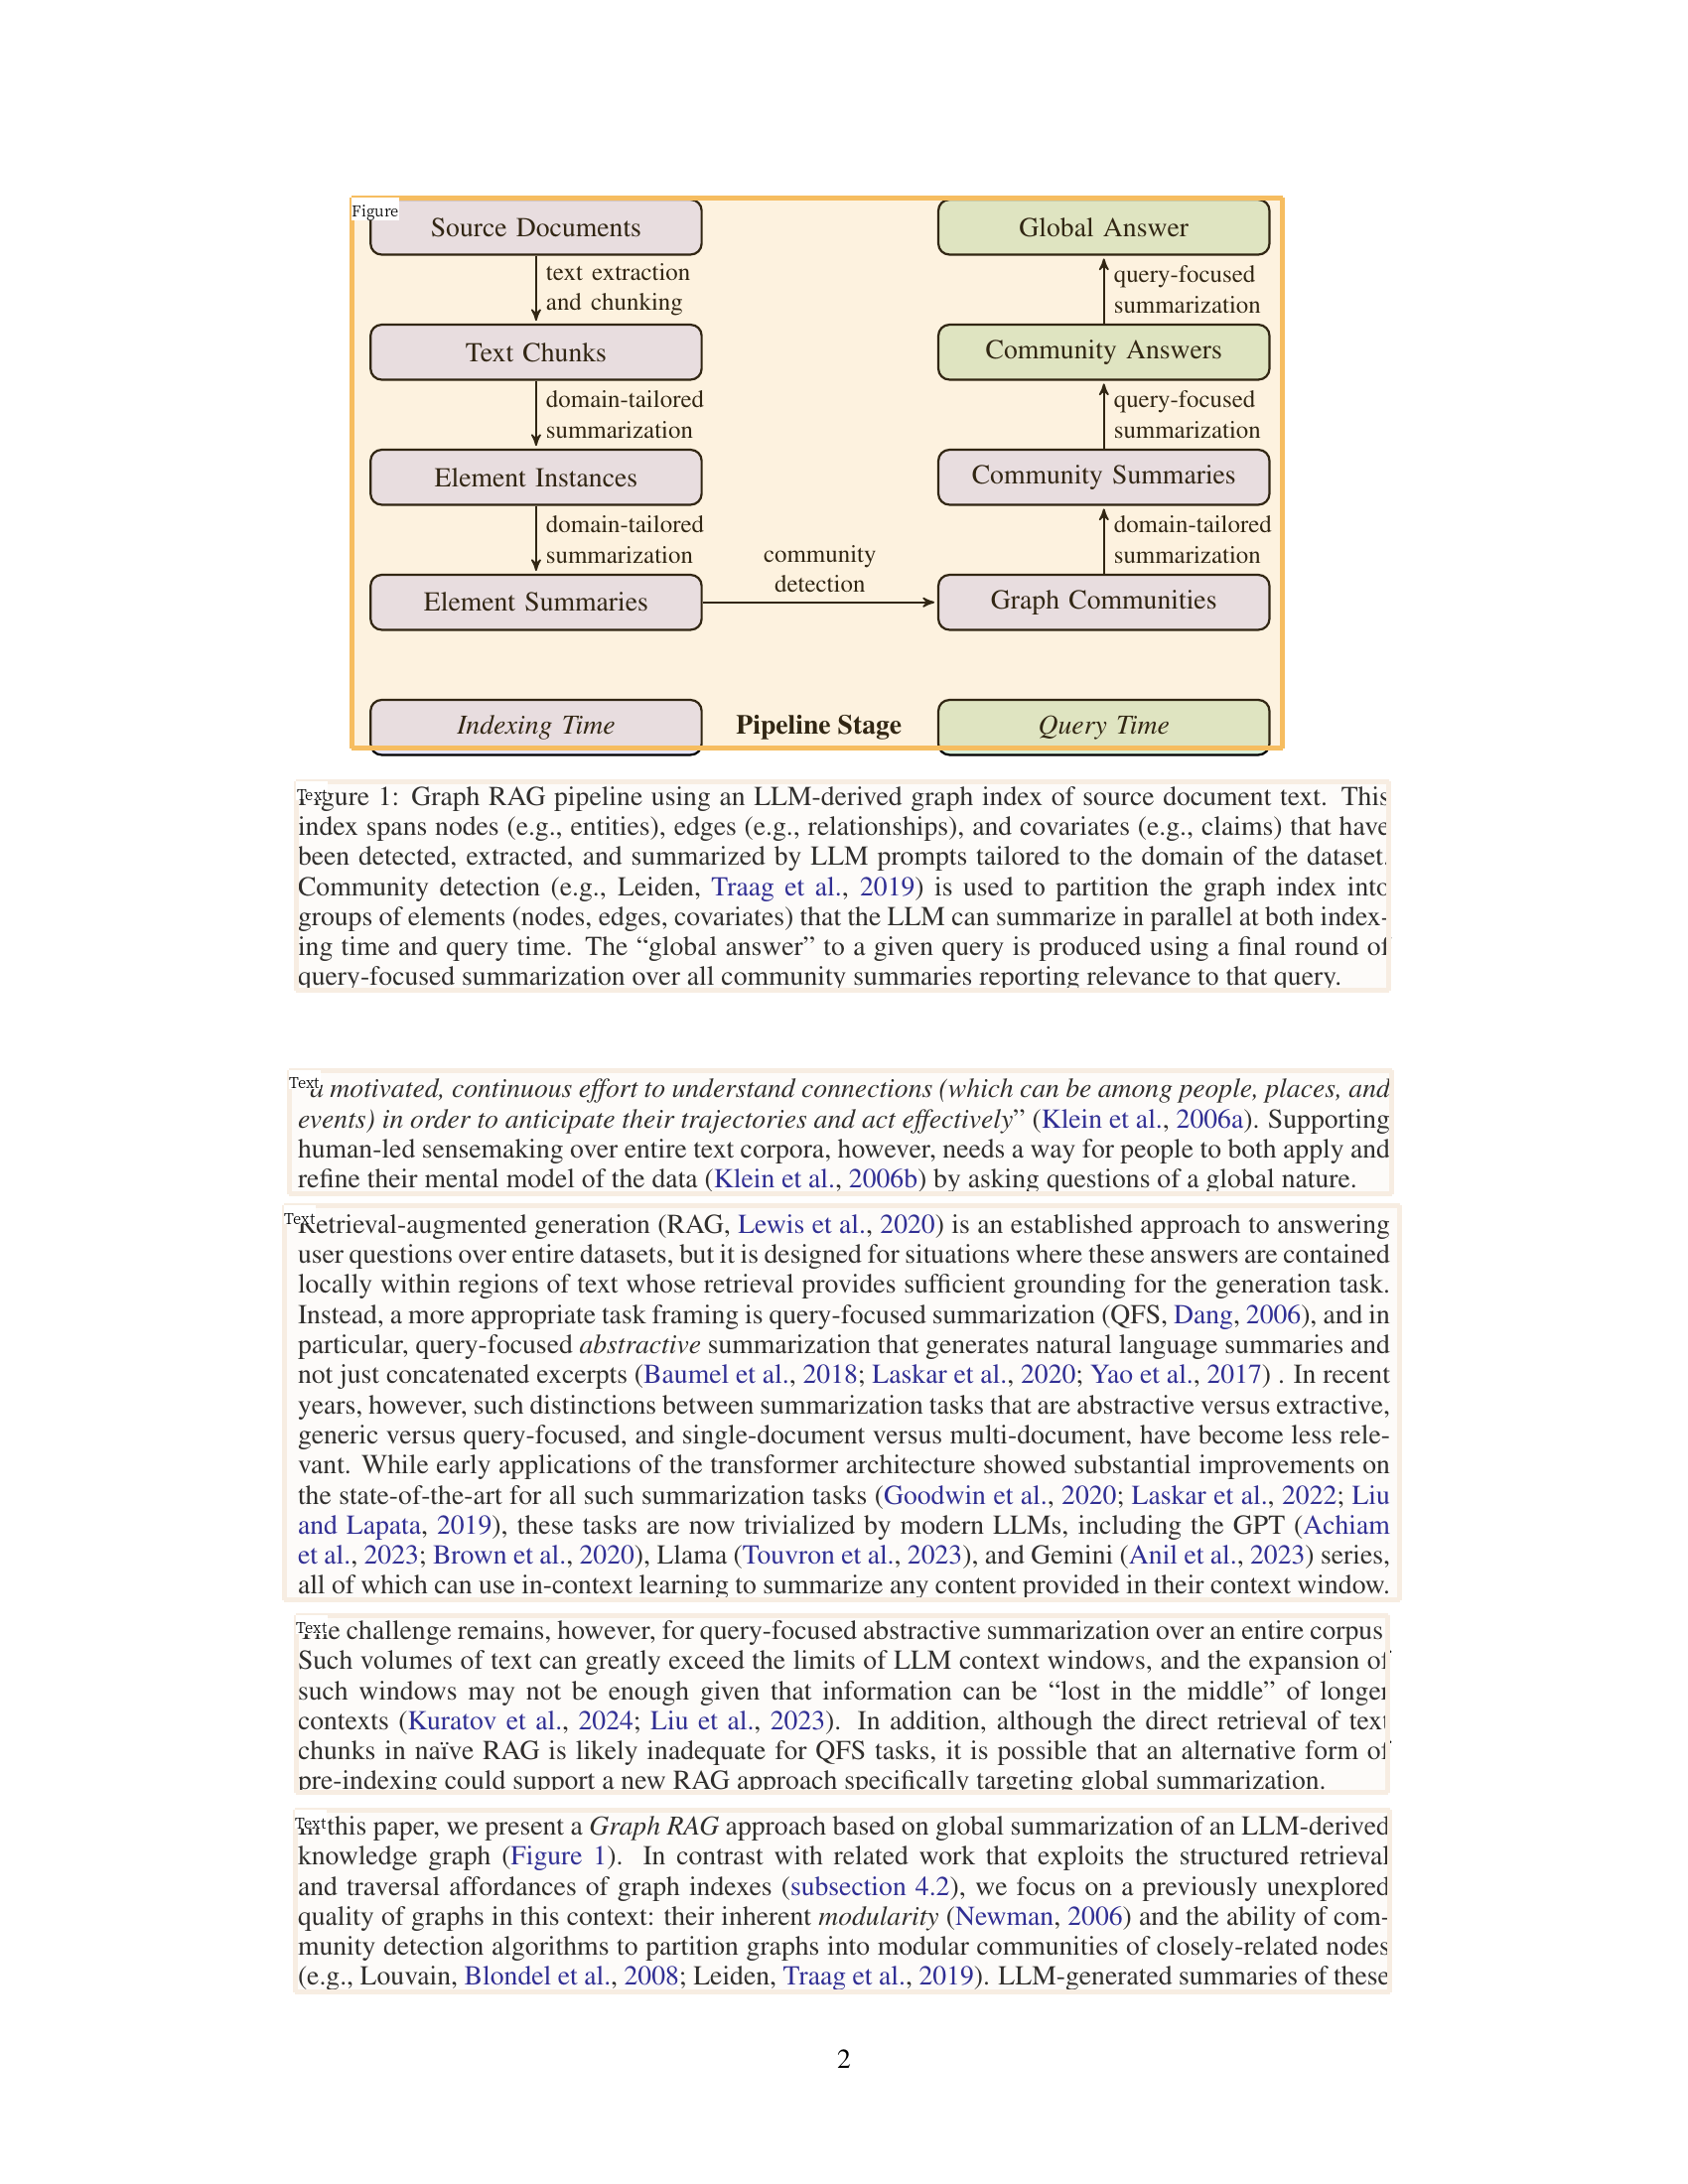

In [ ]:
img = np.asarray(pdf[1])   # 第一頁為 0
detected = layout_model.detect(img)
sorted_detected = sorted(detected, key=custom_sort_key)
lp.draw_box(img, detected, box_width=5, box_alpha=0.2, show_element_type=True)


## 3. RAG (Retrieval Augmented Generation)

### Creating Text Summaries & Vectorspace

In [ ]:
import os
import uuid
import base64
from IPython import display
import faiss
from langchain.chat_models import ChatOpenAI
from langchain.embeddings import OpenAIEmbeddings
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain.schema.messages import HumanMessage, SystemMessage
from langchain.schema.document import Document
from langchain.vectorstores import FAISS
from langchain.retrievers.multi_vector import MultiVectorRetriever

DRIVE_FOLDER = '/content/drive/My Drive/GraphRAG'
FIG_FOLDER = os.path.join(os.path.join(DRIVE_FOLDER), 'Figure')
TABLE_FOLDER = os.path.join(os.path.join(DRIVE_FOLDER), 'Table')
EMBEDDING_TOKEN_LIMITATION = 8191   # 圖像和表格的文字敘述是透過相同 model 輸出的，因此不會超出 token 限制
EMBEDDING_OVERLAP = 500   # 為了讓 embedding 保留前後文的語意
OPEN_API_KEY = "sk-proj-9bKNA50sIYTtjgNnnpg0T3BlbkFJai7TfzQ88trlAV41RuzY"

def encode_image(image_path):
    with open(image_path, "rb") as f:
        return base64.b64encode(f.read()).decode('utf-8')

def describe_image(encoded_image, sysmes, hummes):
  prompt = [
    SystemMessage(content=sysmes),
    HumanMessage(content=[
      {
        "type": "text",
        "text": hummes
      },
      {
        "type": "image_url",
        "image_url": {
          "url": f"data:image/jpeg;base64,{encoded_image}"
        },
      },
    ])
  ]
  response = ChatOpenAI(model="gpt-4-turbo", api_key=OPEN_API_KEY, max_tokens=1024).invoke(prompt)
  return response.content

def get_figure_table_decription(folder):
  for i in os.listdir(folder):
    if i.endswith(('.png', '.jpg', '.jpeg')):
      image_path = os.path.join(folder, i)
      encoded_image = encode_image(image_path)
      if folder == FIG_FOLDER:
        figure_elements.append(encoded_image)
        description = describe_image(encoded_image, "You are a bot that is good at analyzing images.", "Fully describe the contents of this image.")
        figure_descriptions.append(description)
      elif folder == TABLE_FOLDER:
        table_elements.append(encoded_image)
        description = describe_image(encoded_image, "You are a bot that is good at analyzing tables.", "Fully describe the contents of this table.")
        table_descriptions.append(description)

def save_description(img_content, elements, descriptions):
  element_file = os.path.join(DRIVE_FOLDER, f"{img_content}_element.txt")
  description_file = os.path.join(DRIVE_FOLDER, f"{img_content}_description.txt")
  if not os.path.exists(element_file):
    with open(element_file, 'w', encoding='utf-8') as file:
      idx = 1
      for fig in elements:
        file.write(f"<START {idx}>\n{fig}\n<END {idx}>\n")
        idx += 1
  if not os.path.exists(description_file):
    with open(description_file, 'w', encoding='utf-8') as file:
      idx = 1
      for description in descriptions:
        file.write(f"<START {idx}>\n{description}\n<END {idx}>\n")
        idx += 1

def read_content():
  # Text：text_elements / text_descriptions
  text_elements = []
  with open(f'{DRIVE_FOLDER}/text.txt', 'r', encoding='utf-8') as file:
    content = file.read()
    elements = content.split('\n\n')
    for _, element in enumerate(elements):
      # 限制 embedding 的長度 (因為 LLM 有 input token 限制)，以及刪除太短的內容 (通常沒有意義)
      if len(element) > 500:   # 過濾太短的內容
        if len(element) <= EMBEDDING_TOKEN_LIMITATION:
          text_elements.append(element)
        else:   # 將太長的內容分段，並且重疊分段的部分
          for i in range(0, len(element), EMBEDDING_TOKEN_LIMITATION - EMBEDDING_OVERLAP):
            text_elements.append(element[i:i+EMBEDDING_TOKEN_LIMITATION])
  text_descriptions = ["None"]
  # Figure：figure_elements / figure_descriptions
  with open(f'{DRIVE_FOLDER}/figure_element.txt', 'r', encoding='utf-8') as file:
    figure_elements = file.readlines()
  figure_descriptions = []
  with open(f'{DRIVE_FOLDER}/figure_description.txt', 'r', encoding='utf-8') as file:
    content = file.read()
    descriptions = content.split("<START ")
    for fig in descriptions:
      if ">" in fig and "<END " in fig:
        idx_part, desc_part = fig.split(">\n", 1)
        idx = int(idx_part.strip())
        description = desc_part.split(f"\n<END {idx}>")[0].strip()
        figure_descriptions.append(f"Figure {idx}：{description}")
  # Table：table_elements / table_descriptions
  with open(f'{DRIVE_FOLDER}/table_element.txt', 'r', encoding='utf-8') as file:
    table_elements = file.readlines()
  table_descriptions = []
  with open(f'{DRIVE_FOLDER}/table_description.txt', 'r', encoding='utf-8') as file:
    content = file.read()
    descriptions = content.split("<START ")
    for tab in descriptions:
      if ">" in tab and "<END " in fig:
        idx_part, desc_part = tab.split(">\n", 1)
        idx = int(idx_part.strip())
        description = desc_part.split(f"\n<END {idx}>")[0].strip()
        table_descriptions.append(f"Table {idx}：{description}")
    return text_elements, text_descriptions, figure_elements, figure_descriptions, table_elements, table_descriptions

def create_document(content_type, type_elements, type_descriptions):
  for e, s in zip(type_elements, type_descriptions):
    i = str(uuid.uuid4())
    doc = Document(
      page_content = s,
      metadata = {
        'id': i,
        'type': content_type,
        'original_content': e
      }
    )
    retrieve_contents.append((i, e))
    documents.append(doc)



# Get figures & tables' descriptions
figure_elements, figure_descriptions = [], []
get_figure_table_decription(FIG_FOLDER)
save_description("figure", figure_elements, figure_descriptions)
table_elements, table_descriptions = [], []
get_figure_table_decription(TABLE_FOLDER)
save_description("table", table_elements, table_descriptions)
# Create document and vectorspace
documents, retrieve_contents = [], []
text_elements, text_descriptions, figure_elements, figure_descriptions, table_elements, table_descriptions = read_content()
create_document("text", text_elements, text_descriptions)
create_document("figure", figure_elements, figure_descriptions)
create_document("table", table_elements, table_descriptions)
vectorstore = FAISS.from_documents(documents=documents, embedding=OpenAIEmbeddings(api_key=OPEN_API_KEY))
# Store vectorspace
vectorstore_file_path = os.path.join(DRIVE_FOLDER, "vectorspace.index")
faiss.write_index(vectorstore.index, vectorstore_file_path)



# 測試 Embedding 前的內容長度
# for i in range(len(text_elements)):
#   # if len(text_elements[i]) < 500:
#     # print(text_elements[i], '\n\n\n\n\n')
#   print("長度：", len(text_elements[i]))
# print('\n\n')
# for i in range(len(figure_descriptions)):
#   print("長度：", len(figure_descriptions[i]))
# print('\n\n')
# for i in range(len(table_descriptions)):
#   print("長度：", len(table_descriptions[i]))


### Question Answering

/usr/local/lib/python3.10/dist-packages/langchain_community/embeddings/openai.py:272: UserWarning: WARNING! index is not default parameter.
                    index was transferred to model_kwargs.
                    Please confirm that index is what you intended.
  warnings.warn(


The Graph RAG (Retrieval-Augmented Generation) pipeline, based on the provided context, likely operates within the structured process outlined in the flowchart diagram from Figure 1. Here's a step-by-step breakdown of how this pipeline might function, especially focusing on aspects like community detection, summarization, and query-focused operations:

1. **Indexing Time**:
   - **Source Documents**: Initially, source documents are gathered and processed.
   - **Text Extraction and Chunking**: Text is extracted from these documents and segmented into manageable chunks.
   - **Text Chunks**: These chunks serve as the basis for further processing.
   - **Domain-tailored Summarization**: Each chunk is then summarized according to domain-specific criteria.
   - **Element Instances**: These are intermediate summaries derived from the text chunks.
   - **Domain-tailored Summarization (again)**: A secondary summarization process refines the summaries to better fit domain requirements.
   - **

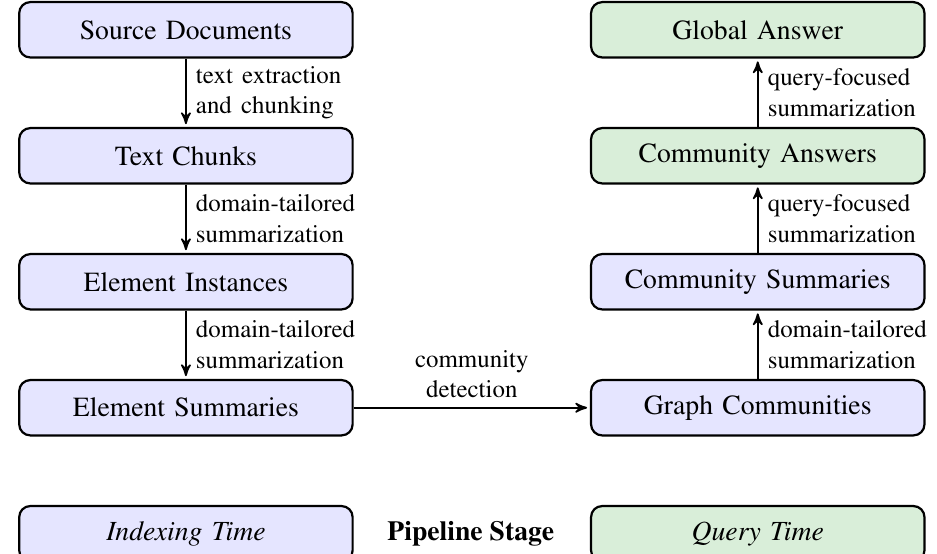

In [ ]:
import os
import base64
from langchain.vectorstores import FAISS
from langchain.embeddings import OpenAIEmbeddings
import faiss
from IPython import display

DRIVE_FOLDER = '/content/drive/My Drive/GraphRAG'
VECTORSTORE_FILE_PATH = os.path.join(drive_folder, "vectorspace.index")
OPEN_API_KEY = "sk-proj-9bKNA50sIYTtjgNnnpg0T3BlbkFJai7TfzQ88trlAV41RuzY"
PROMPT = "How does Graph RAG pipeline work?"
ANWSER_TEMPLATE = """
Answer the question based only on the following context, which can include text, images and tables:
{context}
Question: {question}
"""

def load_vectorstore(vectorstore_path):
  index = faiss.read_index(vectorstore_path)
  embedding_model = OpenAIEmbeddings(index=index, api_key=OPEN_API_KEY)
  return vectorstore

def answer(question):
    relevant_docs = vectorstore.similarity_search(question)
    context = ""
    relevant_images = []
    for d in relevant_docs:
        if d.metadata['type'] == 'text':
            context += '[text]' + d.metadata['original_content']
        elif d.metadata['type'] == 'table':
            context += '[table]' + d.metadata['original_content']
            relevant_images.append(d.metadata['original_content'])
        elif d.metadata['type'] == 'figure':
            context += '[figure]' + d.page_content
            relevant_images.append(d.metadata['original_content'])
    result = answer_chain.run({'context': context, 'question': question})
    return result, relevant_images

def fix_base64_padding(base64_string):
    return base64_string + '=' * (-len(base64_string) % 4)

def display_result(result, relevant_images):
  print(result)
  for e in relevant_images:
    if not (e.startswith("<") or e.endswith(">")):   # 因為我們為了要判斷第幾張圖片和表格，有 <START><END> 會影響到圖像 decoding
      try:
        fixed_e = fix_base64_padding(e)
        print('\n\n')
        display.display(display.Image(base64.b64decode(fixed_e), width=600, height=300))
      except Exception as ex:
        print(f"Error displaying image: {ex}")



# Load vectorspace
answer_chain = LLMChain(llm=ChatOpenAI(model="gpt-4-turbo", api_key=OPEN_API_KEY, max_tokens=1024), prompt=PromptTemplate.from_template(ANWSER_TEMPLATE))
vectorstore = load_vectorstore(VECTORSTORE_FILE_PATH)
# Display result
result, relevant_images = answer(PROMPT)
display_result(result, relevant_images)
